# **Lab 7.1 Data Augmentation with PyTorch**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [ ]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Pad(223,padding_mode="reflect"),
        transforms.RandomAffine(degrees=45, translate=(0.1,0.1), scale=(0.8,1.2), shear=45),
        transforms.CenterCrop(224),
    ])

    dataset = ImageFolder(path,transform=transform)

    classnames = dataset.classes
    # print(classnames)
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _,label in dataset.samples:
        class_counts[dataset.classes[label]] += 1


    print("📃Train Dataset:")
    for i in range(len(classnames)):
        print("\tNumber of images in class", classnames[i],":", class_counts[classnames[i]])

    print("\tNumber of samples:", len(dataset))
    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
    return data_loader, classnames
    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


![image.png](attachment:image.png)

</details>

📃Train Dataset:
	Number of images in class battleship : 44
	Number of images in class patrol boat : 35
	Number of images in class submarine : 35
	Number of samples: 114


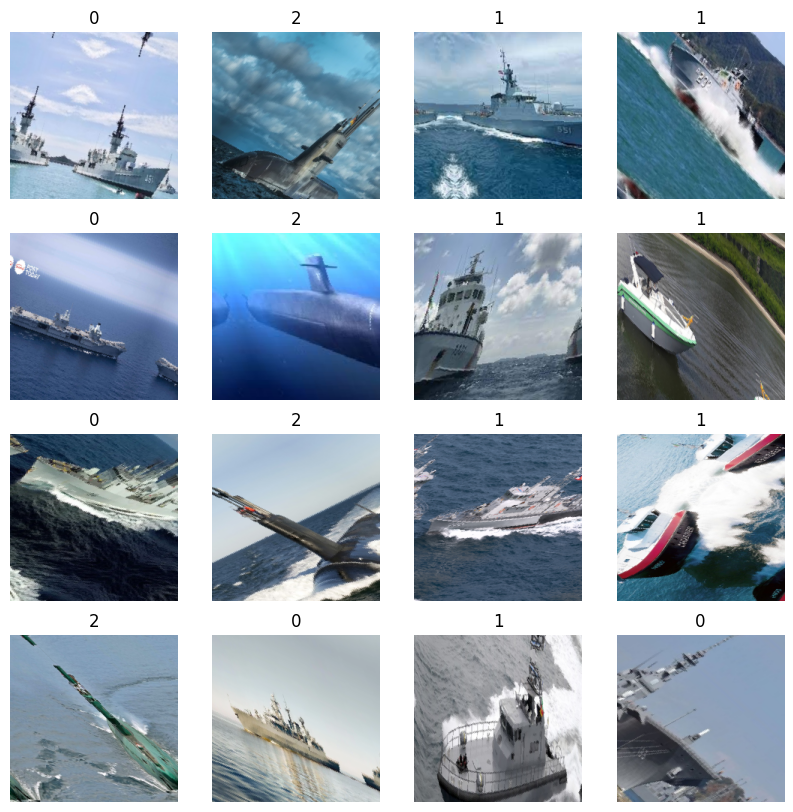

In [ ]:
### START CODE HERE ###
image_dir = "/content/drive/MyDrive/TA/Image processing/Lab4(Augment, CNN-NN)/Dataset/Ship/Train"
data_loader,classnames = load_data(image_dir)
batch,labels = next(iter(data_loader))
# print(labels)
# print(batch.shape, labels.shape)

def imshow_grid(images,labels,classnames):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.ravel()
    for i, _ in enumerate(images):
        image = images[i].permute(1,2,0).numpy()
        axes[i].imshow(image)
        axes[i].set_title(labels[i].detach().numpy())
        axes[i].axis('off')
    plt.show()
imshow_grid(batch,labels,classnames)


### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [ ]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self,data_dir,pad=0,padding_mode=None,gauss_noise=False,gauss_blur=None,resize=True,p=0.5,rotate=0,shear=0,scale = 1.0,center_crop=None,translate=(0,0)):
        self.p = p
        self.resize = resize
        self.pad = pad
        self.padding_mode = padding_mode
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur


        self.rotate = rotate
        self.center_crop = center_crop
        self.translate = translate
        self.scale = scale
        self.shear = shear

        self.classes = sorted(os.listdir(data_dir))
        # print(self.classes)
        self.class_to_idx = {cls_name:idx for idx,cls_name in enumerate(self.classes)}
        # print(self.class_to_idx)
        self.image_files = self._get_image_files(data_dir)


    def _normalize(self,image):
        # print("min-max",image.min(),image.max())
        return (image - image.min())/(image.max()-image.min())

    # def _padding(self, image, pad: tuple, padding_mode='constant'):
    #     image = torch.from_numpy(image).permute(2, 0, 1)
    #     if padding_mode == 'constant':
    #         image = F.pad(image, pad, mode=padding_mode, value=0)
    #     else:
    #         image = F.pad(image, pad, mode=padding_mode)  # 'reflect'
    #     image = image.permute(1, 2, 0).numpy()
    #     return image

    def _padding(self, image, pad: tuple, padding_mode='constant',constant_value=0):
        if padding_mode == 'constant':
            image = np.pad(image, pad, mode=padding_mode, constant_values=constant_value)
        else:
            image = np.pad(image, pad, mode=padding_mode)
        return image


    def _translate(self,image,translate:tuple):
        h,w = image.shape[0],image.shape[1]
        translate_x,translate_y = translate[0],translate[1]
        translate_m = np.array([[1,0,translate_x],[0,1,translate_y]])
        translated_image = cv2.warpAffine(image,translate_m,(w,h))
        return translated_image


    def _rotate(self,image,rotate):
        h,w = image.shape[0],image.shape[1]
        angle = random.randint(rotate[0],rotate[1])
        ###  cv2.getRotationMatrix2D(center, angle, scale)
        ### Parameters:
        ### center: Center of rotation
        ### angle(θ): Angle of Rotation. Angle is positive for anti-clockwise and negative for clockwise.
        ### scale: scaling factor which scales the image
        rotate_matrix = cv2.getRotationMatrix2D((w/2,h/2),angle,1.0)
        rotated_image = cv2.warpAffine(image,rotate_matrix,(w,h))
        return rotated_image

    def _scale(self,image,scale:tuple):
        h,w = image.shape[0],image.shape[1]
        scale_x,scale_y = scale[0],scale[1]
        scaled_matrix = np.array([[scale_x,0,0],[0,scale_y,0]])
        scaled_image = cv2.warpAffine(image,scaled_matrix,(w,h))
        return scaled_image


    # def _shear(self, image, shear:tuple):
    #     h, w = image.shape[0], image.shape[1]

    #     # Get the shear values for x and y
    #     shear_x, shear_y = shear[0], shear[1]

    #     # Create the affine shear matrix
    #     shear_matrix = np.array([[1, shear_x, 0], [shear_y, 1, 0]])

    #     # Apply the affine transformation (shear) using cv2.warpAffine
    #     shear_image = cv2.warpAffine(image, shear_matrix, (w, h), flags=cv2.INTER_LINEAR,borderMode=cv2.BORDER_REFLECT)

    #     return shear_image

    def _shear(self, image, shear: tuple):
        h, w = image.shape[:2]

        # Get shear values from the tuple
        if len(shear) == 2:
            shear_x = random.uniform(shear[0], shear[1])  # shear along x-axis
            shear_y = 0  # No shear along y-axis
        elif len(shear) == 4:
            shear_x = random.uniform(shear[0], shear[1])  # shear along x-axis
            shear_y = random.uniform(shear[2], shear[3])  # shear along y-axis


        # Convert degrees to radians for shear
        shear_x = np.tan(np.radians(shear_x))
        shear_y = np.tan(np.radians(shear_y))

        shear_matrix = np.array([[1, shear_x, 0], [shear_y, 1, 0]])

        # shear_image = cv2.warpAffine(image, shear_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
        # shear_image = cv2.warpAffine(image, shear_matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
        shear_image = cv2.warpAffine(image, shear_matrix, (w, h))

        return shear_image




    def _gaussian_noise(self, image):
        noise_image = random_noise(image, mode='gaussian', var=0.02)
        return noise_image

    def _gaussian_blur(self,image):
        gaussian_kernel_size_pool = [5,7,9,11]
        gauss_kernel_size = random.choice(gaussian_kernel_size_pool)
        gauss_blurimage = cv2.GaussianBlur(image,(gauss_kernel_size, gauss_kernel_size),5)
        return gauss_blurimage

    def _center_crop(self, image,center_crop:int):
        # image = torch.from_numpy(image).permute(2, 0, 1)
        # image = transforms.CenterCrop(image, center_crop)
        # image = image.permute(1, 2, 0).numpy()
        # return image

        h, w, _ = image.shape
        # print(f"before cc : {image.shape}")
        start_x = (w - center_crop) // 2
        start_y = (h - center_crop) // 2
        image = image[start_y:start_y+self.center_crop, start_x:start_x+self.center_crop]
        # print(f"after cc : {image.shape}")
        return image

    def _get_image_files(self, data_dir):
        image_files = []
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            for img in os.listdir(cls_dir):
                image_files.append(os.path.join(cls_dir, img))
        return image_files

    def _get_class_name(self, image_path):
        return os.path.basename(os.path.dirname(image_path))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        class_name = self._get_class_name(image_path)
        label = self.class_to_idx[class_name]
        read_image = cv2.imread(image_path)
        read_image = cv2.cvtColor(read_image,cv2.COLOR_BGR2RGB)
        image = np.copy(read_image)

        if self.resize is not None:
            image = cv2.resize(image,(self.resize,self.resize))

        if self.pad is not None:
                image = self._padding(image,self.pad,self.padding_mode)
                # print("padding size",image.shape)

        if self.rotate is not None:
            if random.random() < self.p:
                image = self._rotate(image,self.rotate)

        if self.translate is not None:
            if random.random() < self.p:
                image = self._translate(image,self.translate)

        if self.scale is not None:
            if random.random() < self.p:
                image = self._scale(image,self.scale)

        if self.shear is not None:
            if random.random() < self.p:
                image = self._shear(image,self.shear)



        if self.gauss_noise is not None:
            if random.random() < self.p:
                image = self._gaussian_noise(image)

        if self.gauss_blur is not None:
            if random.random() < self.p:
                image = self._gaussian_blur(image)

        if self.center_crop is not None:
            image = self._center_crop(image,self.center_crop)

        image = self._normalize(image)
        image = torch.from_numpy(image).permute(2,0,1)
        return image,label
### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-2.png](attachment:image-2.png)

</details>

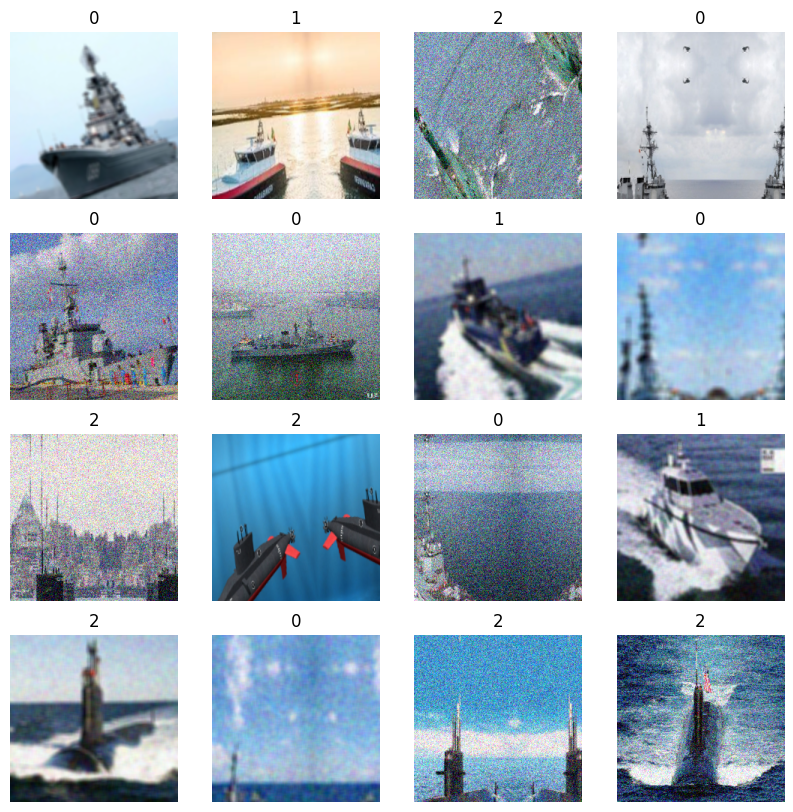

In [ ]:
### START CODE HERE ###

image_dir = "/content/drive/MyDrive/TA/Image processing/Lab4(Augment, CNN-NN)/Dataset/Ship/Train"
# pad จารย์ใช้แบบ left right top bottom  # refer from torch functional.pad doc
dataset = CustomImageDataset(data_dir=image_dir,resize=224,pad=((224,224),(224,224),(0,0)),padding_mode='reflect',rotate=(-45,45),shear=(-0.5,0.5),gauss_noise=True,center_crop=224,p=0.5,translate=(0.1,0.1),scale=(0.8,1.2),gauss_blur=True)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
# print(len(dataset))
batch,labels = next(iter(dataloader))
imshow_grid(batch,labels,classnames)

### END CODE HERE ###


# Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
<br><u>*Ans*</u> <u>effect</u> ของ การ fill หรือ padding คือการที่เราเลือกว่าเราจะเติม pixel ทีว่างที่เกิดจากการ transformation รูปอย่างไรโดย mode มีดังนี้
<br>constant - เติมด้วยค่าคงที่ วิธีนี้อาจจะทำให้เกิดขอบภาพที่ชัดและไม่เป็นธรรมชาติได้
<br>reflect - เป็นวิธีการสะท้อนภาพทำให้ ภาพนั้นดูต่อเนื่องเป็นธรรมชาติมากขึ้น
<br>nearest - เติมด้วยค่า pixel ที่อยู่ใกล้เคียงจากขอบของรูปภาพ ทำให้ยังเก็บรายละเอียดของขอบไว้ได้แต่อาจมี artifact เกิดขึ้นได้
<br>wrap - ทำซ้ำภาพ โดยเอาต้นภาพไปต่อท้ายภาพวนไปเรื่อยๆ ซึ่งอาจทำให้เกิด artifact เช่นเดียวกันกับ nearest
<br>
<br><u>benefit</u>
<ul>
<li>ลด data loss จากการที่ Image นั้นมีส่วนที่ถูกตัดไป เกิน boundaries , ฯลฯ</li>
<li>เพิ่มความต่อเนื่องของภาพ เช่น reflect mode ทำให้ภาพที่ได้ยังคงมีความสมจริง เหมาะแก่การนำไปเทรน </li>
<li>การใช้หลายๆ mode สามารถเพิ่มความหลากหลายให้ตัว dataset ที่เรามีได้</li>
</ul>
2. What would be amount of augmentation should be so that it would not effect the training performance?
<br><u>*Ans*</u>
<br>ควรมีค่า p อยู่ในช่วง 0.3-0.7 เนื่องจากถ้าเรากำหนดให้โอกาสการ augment รูปมากเกินไปอาจทำให้ dataset ที่เรานำไปเทรนนั้นมีแต่รูปที่โดนทำ augment(noise blur transform) เยอะเกินไป จนโมเดลอาจจะทำนายได้ดีเฉพาะรูปที่มี augment แต่อาจทำนายได้ไม่ดีกับรูปที่ปกติจริงๆ
ส่วนถ้าค่า p น้อยก็จะกลับกันกับ p สูง ส่วนค่าของการทำ transform ก็ไม่ควรจะมากเกินไป ควรอิงจาก dataset ที่อิงจากสิ่งแวดล้อมจริงๆบ้างว่าควรมีการทำ augment แบบไหน ตัวอย่างเช่น
<ul>
<li>rotate: ±15° - ±30°
<li>shear: 10% - 30%</li>
<li>scale: 80% - 120%</li>
<li>translate: 5% - 15%</li>
แต่อย่างไรก็ตาม เราควรที่จะปรับค่าที่เหมาะสมกับ dataset ของเรา
</ul>
<br>
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
<br><u>*Ans*</u> คำตอบอยู่ในการ implement โค้ดด้านล่าง
<br>
<br>
<br>
4. What would be transform parameter to simulate camera lense effect?
<br><u>*Ans*</u> ภาพที่จากการถ่ายของกล้องนั้น บางทีจะมีลักษณะบางอย่างที่เกิดขึ้น โดยมีตัวอย่าง ดังนี้
<br>1. barrel distortion เป็นการบิดเบือนของภาพที่ทำให้เหมือนภาพนั้นบวมจากจุดศูนย์กลาง โดย parameter จะเป็นการกำหนดระดับการนูนของภาพ เช่น k1 = 0.5
<br>2. Pincushion Distortion จะตรงข้ามกับ barrel ภาพจะเหมือนโดนกดลงไปแทน โดย parameter จะเป็นการกำหนดระดับการกดของภาพ k1 = 0.5
<br>3. Vignetting คือ ขอบของภาพจะมีแสงมืดกว่าบริเวณตรงกลางของภาพ โดย parameter เป็นการกำหนดระดับความมืดของรอบๆภาพ strength = 0.5  radius = 0.8 คือมืดลง 50%  ระยะ 20%ของขอบภาพ
<br>4. Chromatic Aberration คือการที่ภาพมีสีเพี้ยนไป โดย parameter ที่ใช้จะไปการ shift สีของภาพไปตามแกน x หรือ y และ การ shift แต่ละสีมักจะทำในทิศตรงข้ามกัน
<br>5. Lens Flare เป็นวงกลมแสงในภาพที่เกิดจากการสะท้อนของแสง โดย parameter จะเป็นการสร้าง วงกลมแสงแล้วนำไปบวกเข้าไปในภาพ เช่น radius center brightness ของวงกลม
<br>
<br>

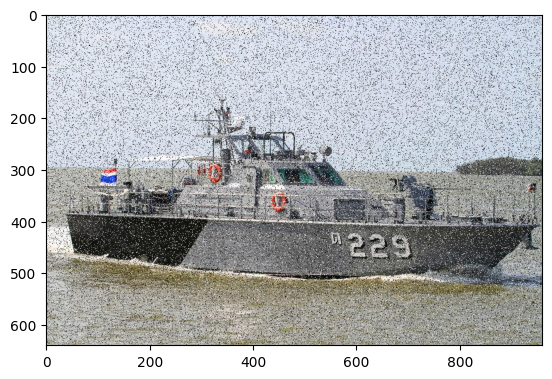

In [ ]:
# ข้อ 3

def add_salt_and_pepper_noise(image, amount=0.05, salt_vs_pepper=0.5):
    noisy_image = np.copy(image)
    # salt
    num_salt = np.ceil(amount * image.size * salt_vs_pepper) # สุ่ม จำนวนของปริมาณเกลือที่จะมีว่าจะมีกี่เม็ด pixel

    salt_coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]  # สุ่มตำแหน่งของเกลือจาก shape ของภาพ
    noisy_image[salt_coords[0], salt_coords[1], :] = 255 #  set ให้ค่า x,y ทั้งหมดที่สุ่มมาด้านบน เป็นสีขาว
    # pepper
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_vs_pepper)) # สุ่ม จำนวนของปริมาณ pepper ที่จะมีว่าจะมีกี่เม็ด pixel โดยหักจากเกลือ
    pepper_coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape] # สุ่มตำแหน่งของ pepper จาก shape ของภาพ
    noisy_image[pepper_coords[0], pepper_coords[1], :] = 0 #  set ให้ค่า x,y ทั้งหมดที่สุ่มมาด้านบน เป็นสีดำ

    return noisy_image

imaged = cv2.imread('/home/tdeephu/takdanai/Lab7_Data-Augmentation-CNN/Ship/Train/patrol boat/p1.jpg')
imaged = cv2.cvtColor(imaged,cv2.COLOR_BGR2RGB)
noisy_imaged = add_salt_and_pepper_noise(imaged, amount=0.05)
plt.imshow(noisy_imaged)